In [1]:
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.random import multivariate_normal
from chainconsumer import ChainConsumer
import matplotlib

<ErrorbarContainer object of 3 artists>

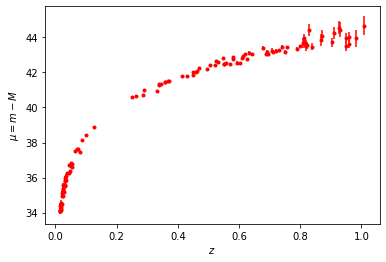

In [2]:
z_obs, m_obs, dm_obs = np.loadtxt("SCPUnion2.1_mu_vs_z.dat", unpack=True)

# plot redshift vs distance modulus
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu = m - M$")
plt.errorbar(z_obs, m_obs, dm_obs, fmt='r.' )


## DATA SETS

### CMB(first peak)

In [3]:
l_cmb = 302.
err_l_cmb = 0.2
z_ls = 1090.

theta_cmb = np.pi / l_cmb
err_theta_cmb = err_l_cmb / l_cmb * theta_cmb

### BAO

In [4]:
bao_file = "theta_bao.dat"

z_bao, theta_deg, err_theta_deg = np.loadtxt(bao_file, unpack=True)

theta_bao = theta_deg * np.pi / 180.
err_theta_bao = err_theta_deg * np.pi / 180.

### SN Ia

In [5]:
z_sn, m_obs, dm_obs_stat = np.loadtxt("SCPUnion2.1_mu_vs_z.dat", unpack=True)
dm_syst = 0.0169
dm_obs = np.sqrt(dm_syst + dm_obs_stat ** 2)

### $\Omega_mh^2$ and Riess 2019

In [6]:
omgMh2_cmb = 0.1426
omgMh2_cmb_error = 0.0020
## Riess 2016 
# H0 = 73.24 +/- 1.74
H0_Riess = 73.24
H0_Riess_error = 1.74


## Strong Gravitational Lensing 

In [7]:
z_l, z_s, D_obs,err_D = np.loadtxt("sgl.dat", unpack=True)

In [8]:
def Ez(z, omgM):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3))
    return Ez


def D_ls(z1,z2,om):
    integral, _ = quad(Ez, z1, z2, epsrel=1e-8, args=(om))
    return integral

def D_s(z,om):
    integral, _ = quad(Ez, 0, z, epsrel=1e-8, args=(om))
    return integral
    
def D_A(z,z1,z2,om):
    D = D_ls(z1,z2,om)/D_s(z,om)
    return D


In [9]:
def chisq_sgl(om,h):
    for z1 in z_l:
        for z2 in z_s:
            D_lsmodel = np.array(D_ls(z1,z2,om))
    for z in z_s:
        D_smodel = np.array(D_s(z,om))
    D_model = D_lsmodel/D_smodel
    chisq = np.power(((D_model-D_obs)/err_D),2)
    return chisq.sum()

#print(chisq_sgl(0.3,0.7))

# LCDM model

In [10]:
def luminosity_integrand(z, omgM):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3))
    return 1. / Ez

def luminosity_distance(z, h, omgM):
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, h, omgM):
    return 5. * np.log10(luminosity_distance(z, h, omgM)) + 25.

In [11]:
def E_inverse(z, omgM):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3))
    return 1. / Ez

def sound_horizon_integrand(z, omgM, omgB, omgG):
    cs = np.power(3 + 9./4 * omgB / (omgG * z), -0.5)
    return cs * E_inverse(z, omgM)

def sound_horizon(z_star, omgM,omgB, omgG):
    integral, _ = quad(sound_horizon_integrand, z_star, np.inf, args=(omgM,omgB, omgG))
    return integral

def angular_distance(z, omgM):
    integral, _ = quad(E_inverse, 0, z, args=(omgM))
    return integral

def theta_model(z, z_star, omgM, omgR, omgB, omgG):
    return sound_horizon(z_star, omgM, omgR, omgB, omgG) / angular_distance(z, omgM, omgR)

In [12]:
h_fid = 0.73
omgB_fid = 0.05
omgG_fid = 5e-5
omgM_fid = 0.3

In [13]:
def chisq_sn(h, omgM):
    m_model = np.array([distance_modulus(z, h, omgM) for z in z_sn])
    chisq_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return chisq_vec.sum()

def chisq_cmb(omgM,omgB, omgG):
    z_star_cmb = 1090
    theta_cmb_model = theta_model(z_ls, z_star_cmb, omgM, omgB, omgG)
    chisq = np.power( (theta_cmb_model - theta_cmb) / err_theta_cmb, 2 )
    return chisq

def chisq_bao(omgM,omgB, omgG):
    z_star_bao = 1060
    theta_bao_model = np.array([theta_model(z, z_star_bao, omgM,omgB, omgG) for z in z_bao])
    chisq = np.sum( np.power( (theta_bao_model - theta_bao) / err_theta_bao, 2 ) )
    return chisq

def chisq_cmb_bao(omgM,omgB, omgG):
    chisq = chisq_cmb(omgM,omgB, omgG) + \
            chisq_bao(omgM,omgB, omgG)
    return chishq

def chisq_cmb2(omgM,h):
    omgMh2_cmb_model = omgM*(h**2)
    chisq = np.power( (omgMh2_cmb_model - omgMh2_cmb) / omgMh2_cmb_error, 2 )
    return chisq

def chisq_Riess(h):
    H0_Riess_model = 100*h
    chisq = np.power( (H0_Riess_model - H0_Riess) / H0_Riess_error, 2 )
    return chisq


### SN Ia + $\Omega_m h^2$

In [14]:
def chisq_sn_om(pars):
    h, omgM = pars
    return chisq_cmb2(omgM,h) + chisq_sn(h, omgM)

In [15]:
result_sn_om = minimize(chisq_sn_om, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_om, omgM_sn_om = result_sn_om.x


In [16]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_om(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_om([h, omgM])

def lnprob_sn_om(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_om(pars)

In [17]:
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_om, omgM_sn_om] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_om, threads=4)
sampler1.run_mcmc(pos, nsteps)

test_chain1 = sampler1.flatchain

In [29]:
c = ChainConsumer()
plot_test_chain1 = [test_chain1[:,0], test_chain1[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain1, parameters=labels, name="SNIa+CMP(perturbation)")

c.configure(legend_artists=True)
#fig = c.plotter.plot()

#matplotlib.pyplot.savefig('plt.png', dpi=520, format='png', bbox_inches='tight')

### SN Ia + $\Omega_mh^2$ + BAO

In [131]:
def chisq_sn_bao(pars):
    h, omgM = pars
    return chisq_bao(omgM,omgB_fid, omgG_fid) + chisq_sn(h, omgM) + chisq_cmb2(omgM,h)

In [63]:
result_sn_bao = minimize(chisq_sn_bao, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_bao, omgM_sn_bao = result_sn_bao.x

In [64]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_bao(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_bao([h, omgM])

def lnprob_sn_bao(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_bao(pars)

In [65]:
# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_bao, omgM_sn_bao] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_bao, threads=4)
sampler2.run_mcmc(pos, nsteps)
test_chain2 = sampler2.flatchain

In [27]:
c = ChainConsumer()
plot_test_chain2 = [test_chain2[:,0], test_chain2[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain2, parameters=labels, name="jjk")

fig = c.plotter.plot()

NameError: name 'test_chain2' is not defined

### SN Ia + $\Omega_mh^2$ + CMB(first peak)

In [19]:
theta = 1.04085
err_theta = 0.00047
r_star = 144.61
z_star =  1090.09
c = 3000.0

In [20]:
def d_A(om):
    I,_ = quad(E_inverse, 0, z_star, args=(om))
    return I


def theta_modell(om,h):
    
    theta = (r_star*h)/(c*(d_A(om)))
    return (100*theta)

def chisq_first_CMB(om,h):
    chisq = ( np.power( (theta_modell(om,h) - theta) / err_theta, 2 ) )
    return chisq


In [21]:
def chisq_sn_cmb(pars):
    h, omgM = pars
    return chisq_first_CMB(omgM,h) + chisq_sn(h, omgM) + chisq_cmb2(omgM,h)

In [22]:
result_sn_cmb = minimize(chisq_sn_cmb, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb, omgM_sn_cmb = result_sn_cmb.x

In [23]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb([h, omgM])

def lnprob_sn_cmb(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb(pars)


In [24]:
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_cmb, omgM_sn_cmb] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb, threads=4)
sampler3.run_mcmc(pos, nsteps)
test_chain3 = sampler3.flatchain

In [26]:
plot_test_chain3 = [test_chain3[:,0], test_chain3[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain3, parameters=labels, name="SNIa+CMB(first peak and perturbation)")

#fig = c.plotter.plot()

AttributeError: 'float' object has no attribute 'add_chain'

### SN Ia + $\Omega_mh^2$ + Riess 2019

In [31]:
def chisq_sn_cmb_R19(pars):
    h, omgM = pars
    return chisq_sn(h, omgM) + chisq_Riess(h) + chisq_cmb2(omgM,h)

In [32]:
result_sn_cmb_R19 = minimize(chisq_sn_cmb_R19, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb_R19, omgM_sn_cmb_R19 = result_sn_cmb_R19.x

In [33]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb_R19(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb_R19([h, omgM])

def lnprob_sn_cmb_R19(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb_R19(pars)

In [ ]:
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_cmb_R19, omgM_sn_cmb_R19] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler4 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb_R19, threads=4)
sampler4.run_mcmc(pos, nsteps)

test_chain4 = sampler4.flatchain

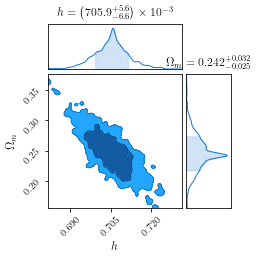

In [30]:
plot_test_chain4 = [test_chain4[:,0], test_chain4[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain4, parameters=labels, name="SNIa+CMB+Riess2019")

#fig = c4.plotter.plot()

### SN Ia + $\Omega_mh^2$ + CMB+SGL

In [ ]:
def chisq_sn_cmb_sgl(pars):
    h, omgM = pars
    return chisq_sn(h, omgM) + chisq_cmb2(omgM,h) + chisq_first_CMB(omgM,h) + chisq_sgl(om,h)

In [ ]:
result_sn_cmb_sgl = minimize(chisq_sn_cmb_sgl, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb_sgl, omgM_sn_cmb_sgl = result_sn_cmb_sgl.x

In [ ]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb_sgl(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb_sgl([h, omgM])

def lnprob_sn_cmb_sgl(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb_sgl(pars)

In [ ]:
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_cmb_sgl, omgM_sn_cmb_sgl] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler5 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb_sgl, threads=4)
sampler5.run_mcmc(pos, nsteps)

test_chain5 = sampler5.flatchain

In [ ]:
plot_test_chain5 = [test_chain5[:,0], test_chain5[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain5, parameters=labels, name="SNIa+CMB+SGL")

In [ ]:
c = ChainConsumer()
plot_test_chain1 = [test_chain1[:,0], test_chain1[:,1]]
plot_test_chain3 = [test_chain3[:,0], test_chain3[:,1]]
plot_test_chain4 = [test_chain4[:,0], test_chain4[:,1]]
plot_test_chain5 = [test_chain5[:,0], test_chain5[:,1]]

labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain1, parameters=labels, name="SNIa+CMP(perturbation)")
c.add_chain(plot_test_chain3, parameters=labels, name="SNIa+CMB(first peak and perturbation)")
c.add_chain(plot_test_chain4, parameters=labels, name="SNIa+CMB+Riess2019")
c.add_chain(plot_test_chain5, parameters=labels, name="SNIa+CMB+SGL")

c.configure(legend_artists=True)
fig = c.plotter.plot()

matplotlib.pyplot.savefig('plt.png', dpi=520, format='png', bbox_inches='tight')